### Swiss roll & Diffusion

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

from sklearn.neighbors import KernelDensity
import scipy.integrate as integrate
from scipy.stats import norm

base_dir = "/Users/yirui/Workspace/machine_learning_projects/Diffusions/data/diffusion/notebook2"


In [4]:
def kl_div(p1, p2):

    p1 = p1 / p1.sum()
    p2 = p2 / p2.sum()

    assert p1.shape == p2.shape
    epsilon = 1e-7
    p1 = np.clip(p1, epsilon, 1)
    p2 = np.clip(p2, epsilon, 1)
    return p1 @ np.log2(p1 / p2)

In [5]:
def kl_div_to_norm(samples):

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples.reshape((-1, 1)))
    log_kde_pdf = kde.score_samples(samples.reshape(-1, 1))
    kde_pdf = np.exp(log_kde_pdf)
    mu, sigma = np.mean(samples), np.std(samples)
    gaussian_pdf = norm.pdf(samples, loc=mu, scale=sigma)

    return kl_div(gaussian_pdf, kde_pdf)
        

In [32]:
f = lambda x: 1 / np.sqrt(2 * np.pi) * np.power(np.e, -x**2/2)
x = np.linspace(-5, 5, 10000)

In [10]:
sample1 = np.random.normal(0, 1, 10000)
sample2 = np.random.normal(5, 3, 1000)

In [39]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(sample1.reshape((-1, 1)))
log_kde_pdf = kde.score_samples(sample1.reshape(-1, 1))
prob = np.power(np.e, log_kde_pdf)

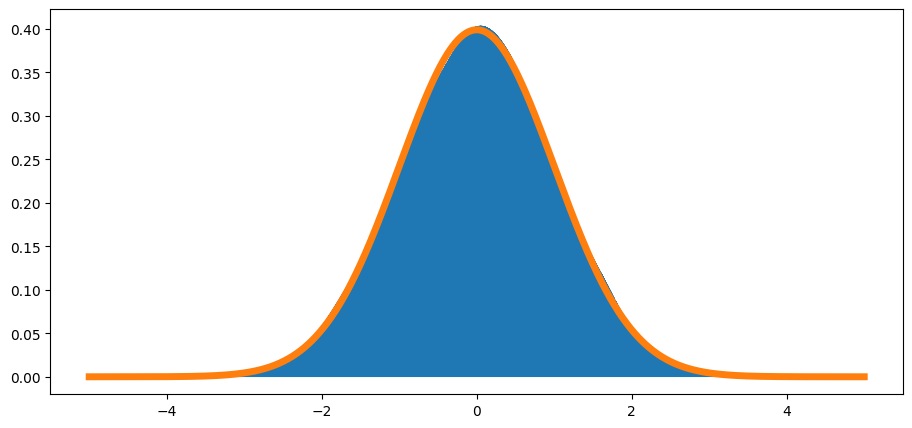

In [ ]:
plt.figure(figsize=(11, 5))

indices = np.argsort(prob)
plt.plot(sample1[indices], prob[indices])

plt.plot(x, f(x), linewidth=5)

# plt.scatter(sample1[indices], prob[indices], color="red", alpha=0.05)


# plt.plot(x, f(x), color="blue")
plt.show()

In [47]:
np.trapz(f(x), x), np.trapz(prob[np.argsort(sample1)], sorted(sample1))

(0.999999426695617, 0.999857273364477)

In [116]:
p1 = np.random.normal(0, 1, 1000000)
h, v = np.histogram(p1, bins=200)
h = h / h.sum()

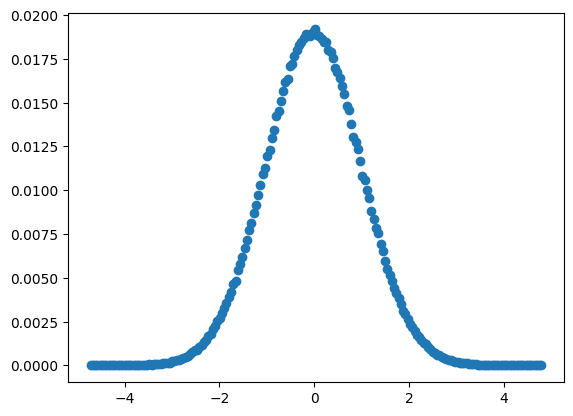

In [ ]:

plt.scatter(v[:-1], h)
plt.scatter(p1[np.argsort(x)], x[np.argsort(x)])
plt.show()

In [98]:
h.sum()

1.0

In [97]:
p1_i.max() - p1_i.min()
# np.sum(h * step)

7.4652304363267925

In [88]:
kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(p1.reshape((-1, 1)))
log_kde_pdf = kde.score_samples(p1.reshape(-1, 1))
x = np.power(np.e, log_kde_pdf)

p1_i = p1[np.argsort(x)]
x_i = x[np.argsort(x)]

step = (p1_i.max() - p1_i.min()) / 10000

np.sum(h * step)

7.465230436326793

In [ ]:
np.lo

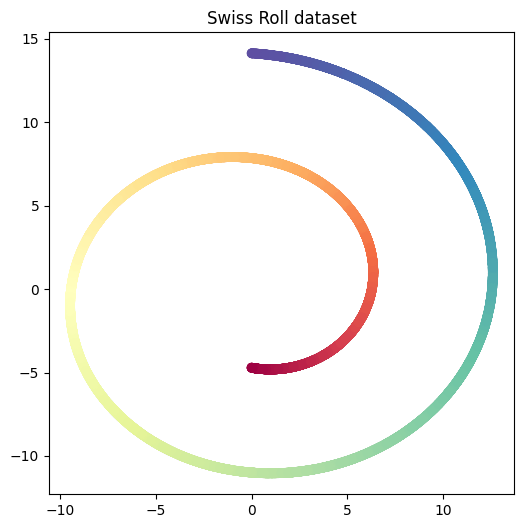

In [46]:

# Generate the Swiss Roll dataset
n_samples = 10000  # You can change this number to get more or fewer data points
noise = 0.0       # You can add some noise to the data
X, color = make_swiss_roll(n_samples=n_samples, noise=noise)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title('Swiss Roll dataset')
plt.show()

In [89]:
os.makedirs(f"{base_dir}/temp", exist_ok=True)
beta = 0.3
X0, X2 = X[:, 0].copy(),  X[:, 2].copy()

x0_min, x0_max = X0.min(), X0.max()
x2_min, x2_max = X2.min(), X2.max()

for i in range(100):

    X0 = X0 + np.random.randn(len(X0)) * beta
    X2 = X2 + np.random.randn(len(X0)) * beta

    if i % 10 == 0:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        ax.scatter(X0, X2, c=color, cmap=plt.cm.Spectral)
        # ax.set_title('Swiss Roll dataset')
        plt.xlim(x0_min - 2, x0_max + 2)
        plt.ylim(x2_min - 2, x2_max + 2)
        kl_x = kl_div_to_norm(X0)
        kl_y = kl_div_to_norm(X2)
        plt.title(f"{round(kl_x, 2)}_{round(kl_y, 2)}")
        #plt.axis("off")
        plt.xlim()
        plt.savefig(f"{base_dir}/temp/{i}.jpeg", dpi=300)
        plt.close()

## Diffusion process

We apply the below formular
$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t}\mathbf{x}_{t-1}, \beta_t \mathbf{I}) \quad q(\mathbf{x}_{1:T} \mid \mathbf{x}_0) = \prod_{t=1}^{T} q(\mathbf{x}_t \mid \mathbf{x}_{t-1})
$$

In [94]:
def apply_noise(vector, beta):

    return np.sqrt(1 - beta) * vector + np.sqrt(beta) * np.random.randn(len(vector))

In [97]:
os.makedirs(f"{base_dir}/temp", exist_ok=True)
beta = 1e-2
X0, X2 = X[:, 0].copy(),  X[:, 2].copy()

x0_min, x0_max = X0.min(), X0.max()
x2_min, x2_max = X2.min(), X2.max()

for i in range(100):

    X0 = apply_noise(X0, beta)
    X2 = apply_noise(X2, beta)

    if i % 5 == 0:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        ax.scatter(X0, X2, c=color, cmap=plt.cm.Spectral)
        # ax.set_title('Swiss Roll dataset')
        plt.xlim(x0_min - 2, x0_max + 2)
        plt.ylim(x2_min - 2, x2_max + 2)
        kl_x = kl_div_to_norm(X0)
        kl_y = kl_div_to_norm(X2)
        plt.title(f"{round(kl_x, 2)}_{round(kl_y, 2)}")
        #plt.axis("off")
        plt.xlim()
        plt.savefig(f"{base_dir}/temp/{i}.jpeg", dpi=300)
        plt.close()

### Reparamization trick

$$
q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I}) \\
\alpha_t = 1 - \beta_t \quad \text{and} \quad \bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i
$$

In [111]:
def sample_from_diff(X, betas):

    alpha_bar = np.prod(1 - np.array(betas))

    return np.sqrt(alpha_bar) * X + np.sqrt(1 - alpha_bar) * np.random.randn(len(X))

In [186]:
folder = f"{base_dir}/temp/reparam"
os.makedirs(folder, exist_ok=True)

beta = 1e-2
X0, X2 = X[:, 0].copy(),  X[:, 2].copy()

x0_min, x0_max = X0.min(), X0.max()
x2_min, x2_max = X2.min(), X2.max()

betas = []
for i in range(100):

    betas.append(beta)

    X0 = sample_from_diff(X[:, 0].copy(), betas)
    X2 = sample_from_diff(X[:, 2].copy(), betas)

    if i % 5 == 0:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        ax.scatter(X0, X2, c=color, cmap=plt.cm.Spectral)
        # ax.set_title('Swiss Roll dataset')
        plt.xlim(x0_min - 2, x0_max + 2)
        plt.ylim(x2_min - 2, x2_max + 2)
        kl_x = kl_div_to_norm(X0)
        kl_y = kl_div_to_norm(X2)
        plt.title(f"{round(kl_x, 2)}_{round(kl_y, 2)}")
        #plt.axis("off")
        plt.xlim()
        plt.savefig(f"{folder}/{i}.jpeg", dpi=300)
        plt.close()

## Reverse diffusion process

### conditional reverse

$$
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; {\tilde{\mu}(\mathbf{x}_t, \mathbf{x}_0)}, {\tilde{\beta}_t \mathbf{I}}) \\
$$
$$
\tilde{\beta}_t = {\frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t} \\
$$
$$
{\tilde{\mu}(\mathbf{x}_t, \mathbf{x}_0)} = \frac{\sqrt{\alpha_t} \left( 1 - \bar{\alpha}_{t-1} \right)}{1 - \bar{\alpha}_t} \mathbf{x}_t 
+ \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0
$$

$$
\alpha_t = 1 - \beta_t
$$

In [165]:
def calculate_beta_tilda(betas, alpha_bar, t):

    return (1 - alpha_bar[t-1]) / (1 - alpha_bar[t]) * betas[t]

In [164]:
def calculate_mu(x_t, x_0, betas, alpha_bar, t):

    fac1 = np.sqrt(1 - betas[t]) * (1 - alpha_bar[t - 1]) / (1 - alpha_bar[t])

    fac2 = np.sqrt(alpha_bar[t - 1]) * betas[t] / (1 - alpha_bar[t])
    
    return fac1 * x_t + fac2 * x_0


In [185]:
folder = f"{base_dir}/temp/reconstruction"
os.makedirs(folder, exist_ok=True)

beta = 1e-2
X0, X2 = X[:, 0].copy(),  X[:, 2].copy()
x0_min, x0_max = X0.min(), X0.max()
x2_min, x2_max = X2.min(), X2.max()

X0_0, X2_0 = X[:, 0].copy(),  X[:, 2].copy()

betas = np.array([beta for _ in range(100)])
alpha_bar = [np.prod((1 - betas[:i])) for i in range(len(betas))]

X0_t = sample_from_diff(X[:, 0].copy(), betas)
X2_t = sample_from_diff(X[:, 2].copy(), betas)

for t in range(99, 0, -1):

    # if t % 5 == 0:

        mu_0_t = calculate_mu(X0_t, X0_0, betas, alpha_bar, t)

        mu_2_t = calculate_mu(X2_t, X2_0, betas, alpha_bar, t)

        mu = np.array([mu_0_t, mu_2_t])

        beta_tilda = calculate_beta_tilda(betas, alpha_bar, t)
        
        var = beta_tilda * np.eye(len(mu))

        samples_t = np.random.multivariate_normal(np.zeros(len(var)), var, mu.shape[-1]) + mu.T

        samples_t = samples_t.T
        
        X0_c, X2_c = samples_t

        fig = plt.figure(figsize=(6, 6))
        
        ax = fig.add_subplot(111)

        ax.scatter(X0_c, X2_c, c=color, cmap=plt.cm.Spectral)

        plt.savefig(f"{folder}/{t}.jpeg", dpi=300)
        plt.close()

0.9890916772953161 0.009696112589746621 99
0.9890916772953161 0.009696112589746621 99
0.9889966258440592 0.009803047394211997 98
0.9889966258440592 0.009803047394211997 98
0.9888994569198164 0.009912114094267597 97
0.9888994569198164 0.009912114094267597 97
0.9888001040431104 0.010023379045167488 96
0.9888001040431104 0.010023379045167488 96
0.9886984979378198 0.010136911398150988 95
0.9886984979378198 0.010136911398150988 95
0.9885945663824381 0.010252783249184737 94
0.9885945663824381 0.010252783249184737 94
0.9884882340517442 0.010371069797300955 93
0.9884882340517442 0.010371069797300955 93
0.9883794223481396 0.010491849513261948 92
0.9883794223481396 0.010491849513261948 92
0.9882680492218684 0.010615204319345262 91
0.9882680492218684 0.010615204319345262 91
0.9881540289792528 0.01074121978111439 90
0.9881540289792528 0.01074121978111439 90
0.988037272077998 0.010869985312117683 89
0.988037272077998 0.010869985312117683 89
0.987917684908541 0.01100159439254391 88
0.987917684908541